總績效 0.8957 
交易次數 42 
平均績效 0.0213 
平均持有天數 80 天
勝率 0.45 
平均獲利 0.0935 
平均虧損 -0.0383 
賺賠比 2.4413 
期望值 0.5568 
獲利平均持有天數 137 天
虧損平均持有天數 33 天
最大連續虧損 -0.0809
最大資金回落 0.2328


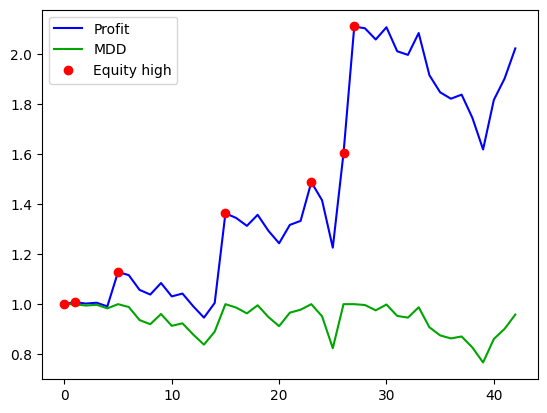

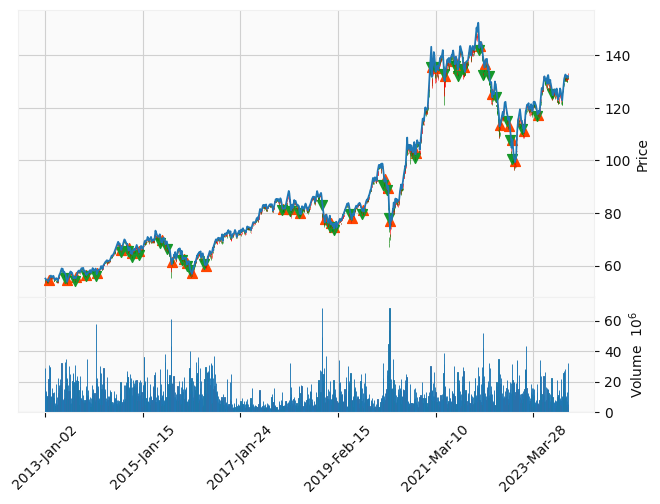

In [1]:
# 載入必要套件
from Data import getDataFM
from BackTest import ChartTrade, Performance
import pandas as pd
import mplfinance as mpf

# 取得回測資料
prod = "0050"
data = getDataFM(prod, "2013-01-01", "2023-12-15")

# 計算前N根K最高價
data["ceil"] = data.rolling(3)["high"].max().shift()
# 移動停損%數
movestoploss = 0.05

# 初始部位
position = 0
trade = pd.DataFrame()
# 開始回測
for i in range(data.shape[0] - 1):
    # 取得策略會應用到的變數
    c_time = data.index[i]
    c_high = data.loc[c_time, "high"]
    c_close = data.loc[c_time, "close"]
    c_ceil = data.loc[c_time, "ceil"]
    # 取下一期資料做為進場資料
    n_time = data.index[i + 1]
    n_open = data.loc[n_time, "open"]

    # 進場程序
    if position == 0:
        # 進場邏輯
        if c_close > c_ceil:
            position = 1
            order_i = i
            order_time = n_time
            order_price = n_open
            order_unit = 1
            stoploss = order_price * (1 - movestoploss)
    # 出場程序
    elif position == 1:
        # 計算移動停損
        stoploss = max(stoploss, c_close * (1 - movestoploss))
        # 出場邏輯
        if c_close < stoploss:
            position = 0
            cover_time = n_time
            cover_price = n_open
            # 交易紀錄
            trade = trade._append(
                pd.Series(
                    [
                        prod,
                        "Buy",
                        order_time,
                        order_price,
                        cover_time,
                        cover_price,
                        order_unit,
                    ]
                ),
                ignore_index=True,
            )

# 繪製副圖
addp = []
addp.append(mpf.make_addplot(data["ceil"]))

# 績效分析
Performance(trade, "ETF")
# 繪製K線圖與交易明細
ChartTrade(data, trade, addp=addp)
